PyTorch CNN to classify sex of college student bust portraits.  
David Clark, DATA 534, Spring 2024 College of Charleston  
CNN structure modeled after Kaggle/Chriszou, at  
https://www.kaggle.com/code/chriszou/dogs-vs-cats-pytorch-cnn-without-transfer-learning/notebook

In [123]:
import os
import random
import time

import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from termcolor import colored
from PIL import Image
import matplotlib.pyplot as plt

Define function to remove a target folder's .DS_store files that could create issues in data loading

In [124]:
#function to remove .DS_store files to avoid issues with dataloader
def remove_ds_store_files(folder):
    # Iterate over all files in the folder
    for file in os.listdir(folder):
        if file == ".DS_Store":
            file_path = os.path.join(folder, file)
            # Check if it's a file and if it's named ".DS_Store"
            if os.path.isfile(file_path):
                # Remove the file
                os.remove(file_path)
                print(f"Removed {file_path}")

Enable the iMac's GPU to expedite training using AMD GPU.

In [125]:
# confirm GPU access; customized for iMac 2020 3.8 GHz 10-core i9 with 128GB RAM and AMD Radeon Pro 5700 XT 16 GB GPU
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print ("GPU enabled - Intel processor with AMD GPU and Apple Metal environment")
else:
    print("WARNING: GPU not seen, operating with CPU only.")

GPU enabled - Intel processor with AMD GPU and Apple Metal environment


Check for training and validation files in data/train directory

In [137]:
img_files = os.listdir('data/train/')
img_files = list(filter(lambda x: x != 'train', img_files))
def train_path(p): return f"data/train/{p}"
    
# remove Data Services file to avoid loading it into dataloader
remove_ds_store_files("data/train")

img_files = list(map(train_path, img_files)) ## returns list of all files in training directory
# count how many of each class
count_females = 0.
count_males = 0.
for root, dirs, files in os.walk('data/train'):
    for file in files:
        if file.startswith('F'):
            count_females +=1.
        elif file.startswith('M'):
            count_males += 1.
male_percent = count_males/len(img_files)
female_percent = count_females/len(img_files)
print("Number of males: {:d}, ({:.0%}), Number of females: {:d}, ({:.0%}) ".format(
            round(count_males), male_percent, round(count_females), female_percent))

# remove Data Services file to avoid loading it into dataloader
remove_ds_store_files("data/train")

print("Total training and validation images: ", len(img_files))
print("The very first image filename is: ", img_files[0])

Number of males: 37638, (31%), Number of females: 82956, (69%) 
Total training and validation images:  120594
The very first image filename is:  data/train/F-20230108-AU-CN-3735_2.jpg


Randomize the training/validation dataset, and split into training and validation datasets.  
Proportion sent to training dataset controlled by constant "TRAINING_PERCENTAGE"

In [138]:
##### split training dataset into training and validation images
random.shuffle(img_files)
TRAINING_PERCENTAGE = 80 ## 80% training, 20% validation
num_training_images = int(len(img_files) * TRAINING_PERCENTAGE / 100)

train = img_files[:num_training_images] # training dataset now has desired proportion of random images from Train folder
validate = img_files[num_training_images:] # validation dataset now has remaining random images from Train folder

print("Training dataset size:  ", len(train))
print("Validation dataset size: ", len(validate))


Training dataset size:   96475
Validation dataset size:  24119


Define input transformation into tensor for all images, then reshape and normalize.
Images must all be the same size (pixel dimensions) for the CNN.
Typically for image classification the inputs are reshaped square.  
Is reshaping to square really necessary given all my portraits are the same rectangular shape and dimensions?

In [139]:
# Tensor creation and normalization of tensor values
transform = transforms.Compose([
    transforms.Resize((224, 224)), # make all the images square
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Define a Greek Portraits Dataset class, with class features.

In [140]:
# Define Dataset class
class GreekPortraitsDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'F-2' in path else 1 #determine ground truth label for image, extracted from filename F-YYYYMMDD... or M-YYYYMMDD...
        return (image, label)

Load the training and validation datasets.

In [141]:
# create training dataset
train_ds = GreekPortraitsDataset(train, transform)
train_dl = DataLoader(train_ds, batch_size=100)
print("Images in training set:  ", len(train_ds), " batchcount = ", len(train_dl))

# create validation dataset
validation_ds = GreekPortraitsDataset(validate, transform)
validation_dl = DataLoader(validation_ds, batch_size=100)
print("Images in validation set: ", len(validation_ds), " batchcount =  ", len(validation_dl))


Images in training set:   96475  batchcount =  965
Images in validation set:  24119  batchcount =   242


Define the architecture of the neural network  
Per chriszou Kaggle model:  
  -- 3 CNNs, with ReLU and max pooling after each, resolution 3, 16, 32 giving 64 outputs, 5x5 kernels on first two, 3x3 kernel on last  
  -- 3 fully connected layers, each with ReLU

In [142]:
# Convolutional Neural Network Model Architecture
# 3 convolution layers, each with ReLU and 2-dimensional max pooling
# 3 fully connected layers, each with ReLU
class MaleFemaleConvNet(nn.Module):

    def __init__(self):
        
        super().__init__()

        # Convolutional layers (3,16,32)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)

        # fully connected layers
        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=2)


    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X

Instantiate a model, then run training and validation epochs.  
Take care to initialize the epoch_limit and use_class_weighting values as you wish.   
   --epoch_limit: integer controlling how many epochs to run  
   --use_class_weighting: boolean controlling whether classes are weighted to correct for unbalanced class sizes in the dataset  
Display accuracies and losses for training and validation after each epoch, along with elapsed time in seconds.

In [143]:
# Create an instance of the model
model = MaleFemaleConvNet()

# Define parameters for the model
epoch_limit = 8             # control how many epochs to run
use_class_weighting = True  # flag controlling whether to weight classes to correct unbalanced dataset
learning_rate = 0.001       # parameter for optimizer

start = time.time()
training_accuracies = [0.]
validation_accuracies = [0.]
training_losses=[1.]
validation_losses=[1.]

#housekeeping - remove system Data Services file if it's there
#remove Data Services file to avoid loading it into dataloader
remove_ds_store_files("data/train")

# Choose whether to use weighting based on logical value of "use_class_weighting" flag

if use_class_weighting:
    # Decided to apply weights to dataset classes to correct for imbalanced class sizes
    # This code section is functional but inelegant; would be cleaner to count each class rather than use external constants for weights
    if female_percent > male_percent:
        # fewer males, so weight them heavier 
        female_weight = 1
        male_weight = female_percent/male_percent
    else:
        # fewer females, so weight them heavier to fix tghe imbalance
        male_weight = 1
        female_weight = female_percent/male_percent
        
    # females are class 0, males are class 1
    weighting_tensor = torch.tensor([female_weight, male_weight], dtype=torch.float32)
    loss_fn = nn.CrossEntropyLoss(weight = weighting_tensor) # assign weights to each class
    print ("Class weighting has been applied based on prevalence of each class in the training and validation dataset.")
else:
    # alternate option: use no weighting, despite unbalanced dataset (69% female)
    loss_fn = nn.CrossEntropyLoss() #classes equally weighted
    print ("No class weighting applied.")

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Model Training...
for epoch in range(1, 1+epoch_limit):

    epoch_loss = 0.
    epoch_accuracy = 0.

    for X, y in train_dl:

        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)

    # calculate accuracy and loss for this training epoch, update running record
    epoch_accuracy = epoch_accuracy/len(train_dl)
    training_accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    training_losses.append(epoch_loss.detach().numpy()) # value only; strip tensor grad

    print("\n --- Epoch: {}, training accuracy: {:.4f}, training loss: {:.4f}, time: {:.1f}".format(
        epoch, epoch_accuracy, epoch_loss, time.time() - start))

    # validation set loss and accuracy
    with torch.no_grad():

        validation_epoch_loss = 0
        validation_epoch_accuracy = 0

        for validation_X, validation_y in validation_dl:

            validation_preds = model(validation_X)
            validation_loss = loss_fn(validation_preds, validation_y)

            validation_epoch_loss += validation_loss            
            validation_accuracy = ((validation_preds.argmax(dim=1) == validation_y).float().mean())
            validation_epoch_accuracy += validation_accuracy

        # calculate accuracy and loss for this validation epoch, update running record
        validation_epoch_accuracy = validation_epoch_accuracy/len(validation_dl)
        validation_accuracies.append(validation_epoch_accuracy.detach().numpy()) # value only; strip tensor grad
        validation_epoch_loss = validation_epoch_loss / len(validation_dl)
        validation_losses.append(validation_epoch_loss.detach().numpy()) # value only; strip tensor grad
        
        print("Epoch: {}, validation accuracy: {:.4f}, validation loss: {:.4f}, time: {:.1f}\n".format(
            epoch, validation_epoch_accuracy, validation_epoch_loss, time.time() - start))

Class weighting has been applied based on prevalence of each class in the training and validation dataset.
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Graph training and validation accuracies by epoch.

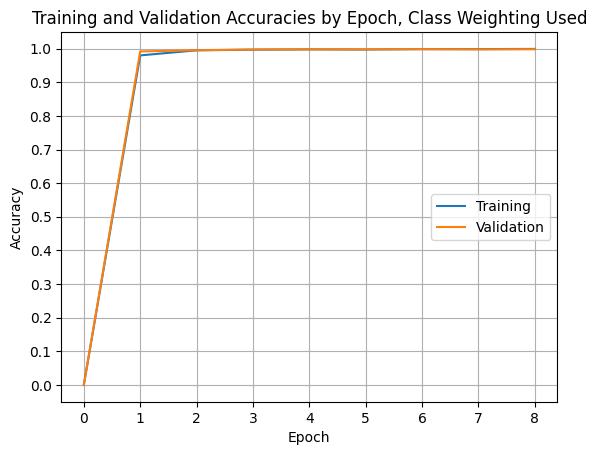

In [157]:
x = list(range(0,epoch_limit+1))
plt.plot(x, training_accuracies, label = "Training")
plt.plot(x, validation_accuracies, label = "Validation")
plt.legend(loc='center right')
plt.xlabel('Epoch')
x_ticks = np.arange(0,epoch_limit+1, 1)
y_ticks = np.arange(0,1.1,0.1)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.ylabel('Accuracy')
plt.grid(True)
plot_title = "Training and Validation Accuracies by Epoch, "
if use_class_weighting:
    plot_title += "Class Weighting Used"
else:
    plot_title += "Class Weighting NOT Used"
plt.title(plot_title)
plt.show()

Graph training and validation losses by epoch.

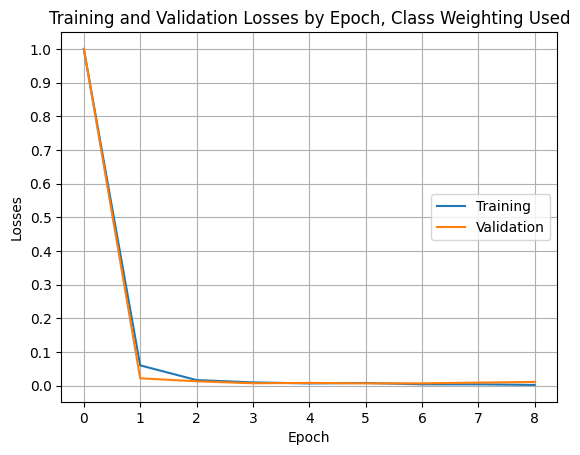

In [145]:
plt.plot(x, training_losses, label = "Training")
plt.plot(x, validation_losses, label = "Validation")
plt.legend(loc='center right')
plt.xlabel('Epoch')
x_ticks = np.arange(0,epoch_limit+1, 1)
y_ticks = np.arange(0,1.1,0.1)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.ylabel('Losses')
plt.grid(True)
plot_title = "Training and Validation Losses by Epoch, "
if use_class_weighting:
    plot_title += "Class Weighting Used"
else:
    plot_title += "Class Weighting NOT Used"
plt.title(plot_title)
plt.show()

Now, challenge the trained model using test images it has never before seen.  
Prepare for testing by loading the previously unseen test images from the "test" folder.

In [153]:
# remove Data Services file to avoid complications
remove_ds_store_files("data/train")

test_files = os.listdir('data/test/')
test_files = list(filter(lambda x: x != 'test', test_files))
test_files = list(filter(lambda x: x != '.DS_Store', test_files))
def test_path(p): return f"data/test/{p}"
test_files = list(map(test_path, test_files))
# test_files.remove('data/test/.DS_Store')

class TestMaleFemaleDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        fileid = path.split('/')[-1].split('.')[0]
        return (image, fileid)

test_ds = TestMaleFemaleDataset(test_files, transform)
test_dl = DataLoader(test_ds, batch_size=100)
print("Length of test dataset: ", len(test_ds))
print ("First test file: ", test_files[0])

Length of test dataset:  2232
First test file:  data/test/F-20190319-USC-AGD-3277.jpg


Conduct the challenge test on the unseen images.

In [154]:
male_probabilities = []
actual_males = []
    
with torch.no_grad():
    for X, fileid in test_dl:
        predictions = model(X)
        predictions_list = F.softmax(predictions, dim=1)[:, 1].tolist()
        male_probabilities += list(zip(list(fileid), predictions_list))

Look at the first few images to see how they were classified.

Original file name:  F-20190319-USC-AGD-3277 Predicted p(M): 0.0% Predicted p(F): 100.0%, Classified as Female Correct


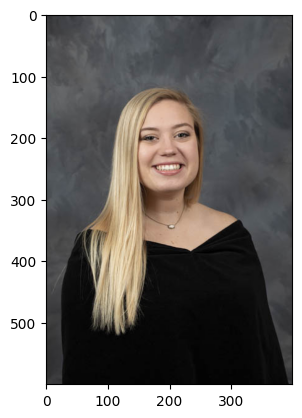

Original file name:  F-20170921-USC-ADP-0065 Predicted p(M): 0.0% Predicted p(F): 100.0%, Classified as Female Correct


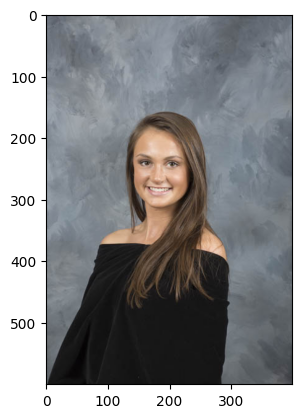

Original file name:  F-20201118-AU-ZTA-7270 Predicted p(M): 0.0% Predicted p(F): 100.0%, Classified as Female Correct


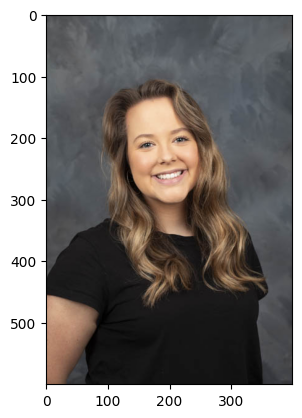

Original file name:  F-20230127-AU-CN-5064 Predicted p(M): 0.0% Predicted p(F): 100.0%, Classified as Female Correct


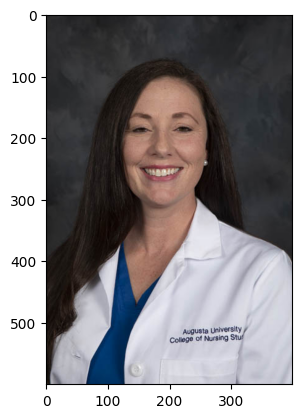

Original file name:  M-20230226-CCU-PKP-6423 Predicted p(M): 100.0% Predicted p(F): 0.0%, Classified as Male Correct


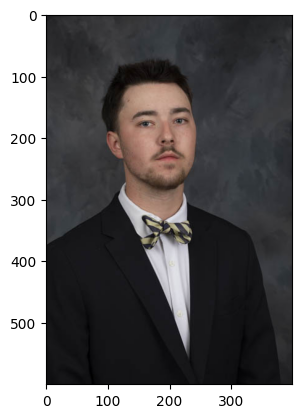

Original file name:  F-20190319-USC-AGD-3539 Predicted p(M): 0.0% Predicted p(F): 100.0%, Classified as Female Correct


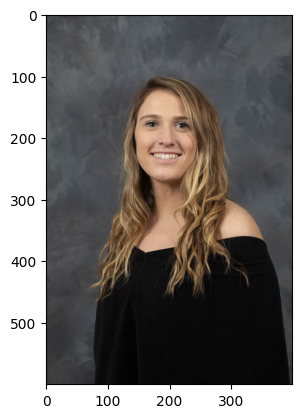

Original file name:  M-20190331-CCU-PKP-4115 Predicted p(M): 100.0% Predicted p(F): 0.0%, Classified as Male Correct


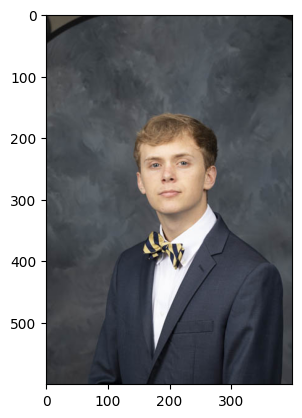

Original file name:  F-20230318-CofC-KD-7374 Predicted p(M): 0.0% Predicted p(F): 100.0%, Classified as Female Correct


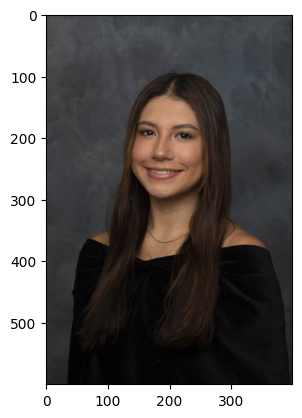

Original file name:  F-20181024-USC-ADP-8578 Predicted p(M): 0.0% Predicted p(F): 100.0%, Classified as Female Correct


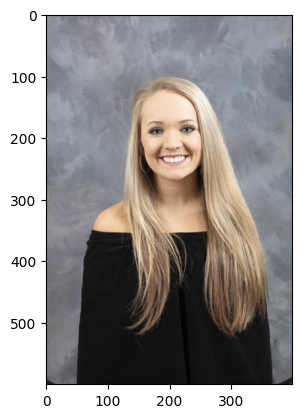

Original file name:  F-20201022-USC-ZTA-6890 Predicted p(M): 0.0% Predicted p(F): 100.0%, Classified as Female Correct


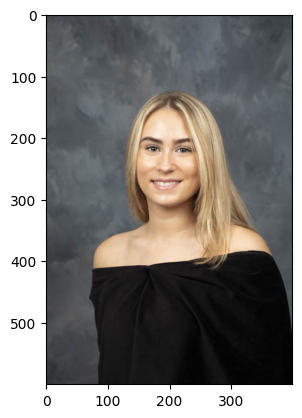

In [155]:
# display the first ten images with their predicted sex
for img, prob in zip(test_files[:10], male_probabilities[:10]):
    pil_im = Image.open(img, 'r')
    image_file_name = prob[0]
    print ("Original file name: ", image_file_name, end = " ")
    label = "Male" if prob[1] > 0.5 else "Female"
        
    title = print("Predicted p(M): {:.1f}% Predicted p(F): {:.1f}%, Classified as {}".format(
        prob[1]*100, (1-prob[1])*100, label), end = " ")
    if image_file_name[:1] == label[0]:
        print (colored("Correct","green"))
    else:
        print (colored("ERROR*****************","red"))
    
    plt.figure()
    plt.imshow(pil_im)
    plt.suptitle(title)
    plt.show()
  

Identify and show all images in the test group that were misclassified (list all errors).  
Finally, calculate values for confusion matrix and the performance measures accuracy, precision, recall, and f-measure.

CLASSIFICATION ERROR*****************
Error classifying test image file data/test/F-20210219-CofC-SDT-8479.jpg
Predicted p(M): 94.3% Predicted p(F): 5.7%, Wrongly classified as M


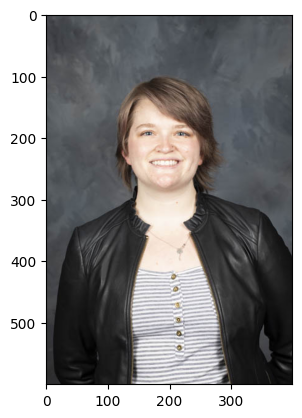

Total number of test images:  2232
Total number of incorrect image classifications:  1
Classification error rate (percentage misclassified) = 0.0448%
Classification accuracy (percentage classified correctly) = 99.9552%

Confusion Matrix and Performance Measures
Predicted Male was Male:  702
Predicted Male was Female:  1
Predicted Female was Male:  0
Predicted Female was Female:  1529
Accuracy:  0.9996
Precision: 0.9986
Recall:    1.0000
F-measure: 0.9993


In [156]:
# display all test images that had an incorrect predicted sex
err_count = 0
predicted_male_was_male = 0
predicted_male_was_female = 0
predicted_female_was_female = 0
predicted_female_was_male = 0

for img, prob in zip(test_files, male_probabilities):
    pil_im = Image.open(img, 'r')
    correct_sex = img[10] # image name includes path data/test; 11th character is "M" or "F"
    predicted_sex = "M" if prob[1] >= 0.5 else "F"

    if predicted_sex != correct_sex:
        print (colored("CLASSIFICATION ERROR*****************","red"))
        print ("Error classifying test image file",img)
        title = print("Predicted p(M): {:.1f}% Predicted p(F): {:.1f}%, Wrongly classified as {}".format(
                        prob[1]*100, (1-prob[1])*100, predicted_sex))
        err_count+=1
        if predicted_sex == "M":
           predicted_male_was_female += 1
        else:
           predicted_female_was_male += 1 
        plt.figure()
        plt.imshow(pil_im)
        plt.suptitle(title)
        plt.show()
    else:
        if correct_sex == "M":
            predicted_male_was_male += 1
        else:
            predicted_female_was_female += 1
        
print ("Total number of test images: ", len(test_files))
print ("Total number of incorrect image classifications: ", err_count)
print("Classification error rate (percentage misclassified) = {:.4f}%".format(err_count / len(test_files) * 100))
print("Classification accuracy (percentage classified correctly) = {:.4f}%".format((len(test_files)-err_count)/len(test_files)*100))

'''
# Unable to install Tabulate library, or would use it to print a pretty table
from tabulate import tabulate
table = [['', 'Predicted Male', 'Predicted Female'], 
         ['Actual Male', predicted_male_was_male, predicted_female_was_male],
         ['Actual Female', predicted_male_was_female, predicted_female_was_female]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))
'''

print ("\nConfusion Matrix and Performance Measures")
print ('Predicted Male was Male: ', predicted_male_was_male)
print ('Predicted Male was Female: ', predicted_male_was_female)
print ('Predicted Female was Male: ', predicted_female_was_male)
print ('Predicted Female was Female: ', predicted_female_was_female)
accuracy = (predicted_male_was_male + predicted_female_was_female) / len(test_files)
precision = predicted_male_was_male / (predicted_male_was_male + predicted_male_was_female)
recall = predicted_male_was_male / (predicted_male_was_male + predicted_female_was_male) 
f_measure = 2*predicted_male_was_male / (2*predicted_male_was_male + predicted_female_was_male + predicted_male_was_female)
print("Accuracy:  {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall:    {:.4f}".format(recall))
print("F-measure: {:.4f}".format(f_measure))
